In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
pd.options.mode.chained_assignment = None
import geopandas as gpd
import squarify 
from api_key import api_key

In [2]:
# prediction dependencies
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [3]:
# load file from webscrape 
path = './output/houses_geocoded.csv'
df = pd.read_csv(path)

# drop imported index column
df = df.drop(['Unnamed: 0'], axis=1)

# Format data types
numeric_columns = ['beds','baths','size']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [4]:
df

,address,price,city,state,zipcode,beds,baths,size,type,lat,lng
0,2226 Pecan Grove Ct,503900,Dallas,TX,75228,3.0,3.0,2434,House,32.811456,-96.703775
1,9615 Limestone Dr,145000,Dallas,TX,75217,3.0,2.0,1057,House,32.744224,-96.656066
2,2714 Burger Ave,155000,Dallas,TX,75215,3.0,2.0,912,House,32.764402,-96.763974
3,351 Crenshaw Dr,199000,Dallas,TX,75217,4.0,2.0,1360,House,32.706745,-96.655701
4,2212 Lowery St,265000,Dallas,TX,75215,3.0,2.0,1366,House,32.743627,-96.757222
...,...,...,...,...,...,...,...,...,...,...,...
648,10226 Pinecrest Dr,249000,Dallas,TX,75228,2.0,1.0,988,House,32.833550,-96.685872
649,3458 Saint Cloud Cir,450000,Dallas,TX,75229,3.0,2.0,2331,House,32.907627,-96.862018
650,5505 Charlestown Dr,1495000,Dallas,TX,75230,5.0,5.0,4897,House,32.917888,-96.816164
651,8435 Coppertowne Ln,325000,Dallas,TX,75243,3.0,2.0,1855,Townhouse,32.895364,-96.727046


## Exploration 

In [5]:
df.describe()

,price,zipcode,beds,baths,size,lat,lng
count,6.530000e+02,653.000000,652.000000,652.000000,653.000000,653.000000,653.000000
mean,7.251972e+05,75225.490046,3.239264,3.009202,2483.647779,32.923962,-96.689588
std,1.246528e+06,16.550313,1.021034,1.607368,1903.127118,0.925931,1.189179
min,7.500000e+04,75201.000000,2.000000,1.000000,612.000000,32.640390,-98.459232
25%,2.550000e+05,75214.000000,2.000000,2.000000,1389.000000,32.777977,-96.824812
50%,4.149000e+05,75225.000000,3.000000,3.000000,1988.000000,32.825454,-96.796215
75%,6.499990e+05,75235.000000,4.000000,3.000000,2780.000000,32.891494,-96.747716
max,1.500000e+07,75287.000000,8.000000,12.000000,18589.000000,45.445625,-75.436881


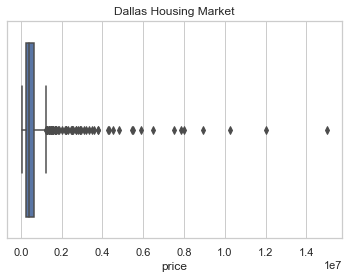

In [6]:
# Box plot to show distribution 
prices = df['price']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=prices)
plt.title('Dallas Housing Market')
plt.show()

In [7]:
# remove extreme outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
houses = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f'Number of outliers: {len(df) - len(houses)}')

Number of outliers: 115


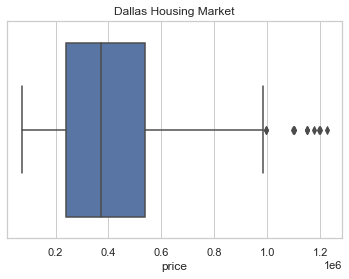

In [8]:
# boxplot without the outliers
prices = houses['price']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=prices)
plt.title('Dallas Housing Market')
plt.show()

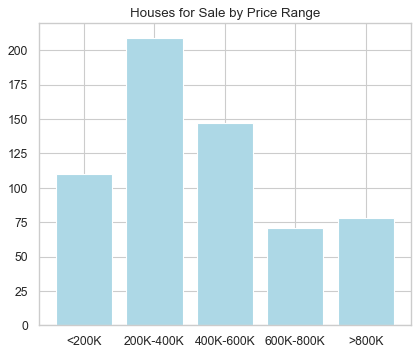

In [9]:
# Create bins for spending ranges and respective labels 
price_ranges = [0, 200000, 400000, 600000, 800000, 2000000]
spending_ranges = ["<200K", "200K-400K", "400K-600K", "600K-800K", ">800K"]
df['spending ranges'] = pd.cut(df["price"], price_ranges, labels=spending_ranges, include_lowest=False)

# count how many in each bin
count = df.groupby('spending ranges')['address'].count()

# plot
plt.figure(figsize=(6,5), dpi= 80)
plt.bar(spending_ranges, count, color='lightblue')
plt.title('Houses for Sale by Price Range')
plt.savefig('./output/price_range.png')
plt.show()

In [10]:
# Most expensive zip codes 
spending_zipcodes = pd.pivot_table(df, index=['spending ranges','zipcode'], values=['size', 'baths', 'beds'])

# formatting to make it prettier 
spending_zipcodes['beds'] = spending_zipcodes['beds'].map("{:.0f}".format)
spending_zipcodes['baths'] = spending_zipcodes['baths'].map("{:.0f}".format)
spending_zipcodes['size'] = spending_zipcodes['size'].map("{:.0f}".format)

spending_zipcodes

baths beds  size
spending ranges zipcode                 
<200K           75203       2    3  1690
                75206       2    2  1096
                75210       2    3  1210
                75211       1    3   991
                75212       1    2   612
...                       ...  ...   ...
>800K           75244       4    4  3586
                75248       5    5  4220
                75252       4    5  4578
                75254       4    4  3837
                75287       7    5  6387

[143 rows x 3 columns]

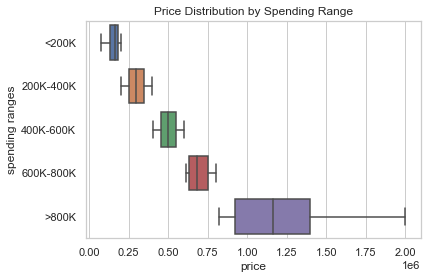

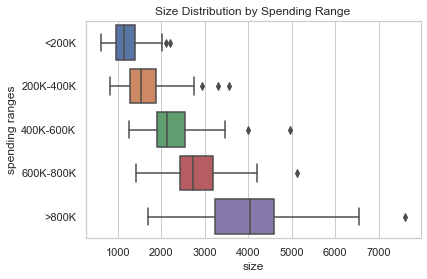

In [11]:
# df_spending = df.loc[df['spending ranges'] != '>800K']

# Boxplot of price by spending range
ax = sns.boxplot(x="price", y="spending ranges", data=df)
sns.set_theme(style="whitegrid")
plt.title('Price Distribution by Spending Range')
plt.show()

# Size by spending range 
ax = sns.boxplot(x="size", y="spending ranges", data=df)
sns.set_theme(style="whitegrid")
plt.title('Size Distribution by Spending Range')
plt.show()


In [12]:
# api_key = api_key 
# url = 'http://api.positionstack.com/v1/forward?'

# for i, row in houses.iterrows():
#     address = row['address']
#     query = url + "access_key=" + api_key + '&query=' + address
#     try:
#         response = requests.get(query).json()
#         houses.loc[i,'lat'] = response['data'][0]['latitude']
#         houses.loc[i,'lng'] = response['data'][0]['longitude']
#     except:
#         pass

In [14]:
## Save as csv to avoid running the api again
# houses.to_csv('./output/houses.csv')

# If restarting kernel run:
# houses = pd.read_csv('./output/houses.csv')

### Plot on geomap

In [15]:
# dallasMap = gpd.read_file('./streets/streets.shp')
# dallasMap.plot(figsize=(6,6))
# plt.show()

In [16]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=37.5, lon_0=-119,
#             width=1E6, height=1.2E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=np.log10(population), s=area,
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');

In [17]:
# # Plot heatmap/color-coded scatter plot grouped by price 
# api = api_key
# for i, row in df.iterrows():
#     address = row[0]
#     city = row[5] # narrows down search results 
#     url = 'https://api.tomtom.com/search/2/geocode/' + address + ' ' + city + '.json?storeResult=false&typeahead=false&' + 'key=' + api

#     response = requests.get(url).json()
#     df.loc[i, 'lat'] = response['position']['lat']
#     df.loc[i, 'lng'] = response['position']['lng']

### Biggest house you can buy for each budget 


In [18]:
by_budget = df.groupby('spending ranges')['size'].max()
by_budget = pd.DataFrame(
    {'Largest house': by_budget}
)
by_budget

,Largest house
spending ranges,
<200K,2208
200K-400K,3552
400K-600K,4960
600K-800K,5116
>800K,7614


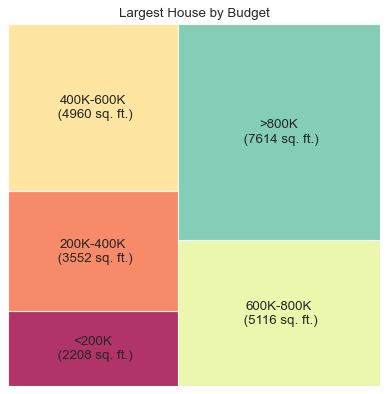

In [19]:
# Sizes
sizes = by_budget['Largest house']
budget = by_budget.reset_index() # To apply labels 
labels = budget.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + " sq. ft." + ")", axis=1)
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(6,6), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Formatting
plt.title('Largest House by Budget')
plt.axis('off')
plt.show()

## Size 

In [20]:
# Calculate cost per square foot 
price_sqft = df.price / df.size
df['price per sqft'] = price_sqft

# Avg size by spending range 
avg_size = df.groupby('spending ranges')['size'].mean().round()

# Average price per square foot by spending range 
budget_sqft = df.groupby('spending ranges')['price per sqft'].mean()
budget_sqft = pd.DataFrame(budget_sqft)
budget_sqft['avg size'] = avg_size
budget_sqft

,price per sqft,avg size
spending ranges,,
<200K,19.987148,1217.0
200K-400K,38.939156,1603.0
400K-600K,64.259739,2240.0
600K-800K,88.398951,2869.0
>800K,153.511713,4002.0


#### without outliers:

In [23]:
# Calculate cost per square foot (houses df to avoid outlier)
price_sqft = df.price / df.size
df['price per sqft'] = price_sqft

# Average price per square foot by spending range 
houses_sqft = df.groupby('spending ranges')['price per sqft'].mean()
houses_sqft = pd.DataFrame(houses_sqft)

avg_size = df.groupby('spending ranges')['size'].mean().round()
houses_sqft['avg size'] = avg_size
houses_sqft

,price per sqft,avg size
spending ranges,,
<200K,18.449675,1217.0
200K-400K,35.943837,1603.0
400K-600K,59.316682,2240.0
600K-800K,81.599032,2869.0
>800K,141.703120,4002.0


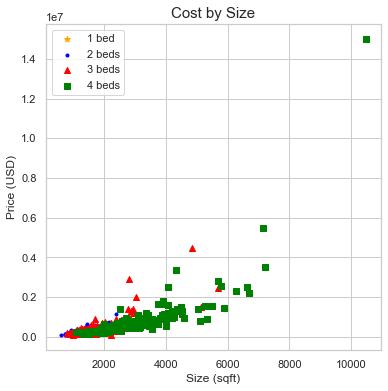

In [24]:
## scatterplot for size and price

# find by number of beds
oneBd = df[(df.beds == 1)]
twoBd = df[(df.beds == 2)]
threeBd = df[(df.beds == 3)]
fourBd = df[(df.beds == 4)]

plt.figure(figsize=(6,6))
plt.scatter(oneBd['size'], oneBd['price'], color='orange',label='1 bed', marker='*')
plt.scatter(twoBd['size'], twoBd['price'], color='blue',label='2 beds', marker='.')
plt.scatter(threeBd['size'], threeBd['price'], marker='^', color='red',label='3 beds')
plt.scatter(fourBd['size'], fourBd['price'], marker=',', color='green',label='4 beds')

plt.xlabel("Size (sqft)")
plt.ylabel("Price (USD)")
plt.title('Cost by Size', fontsize=15)
plt.legend()
    
plt.show()

In [25]:
## scatterplot by zipcode 
def plot_scatter_chart(df,zipcode):
    oneBd = df[(df.zipcode == zipcode) & (df.beds == 1)]
    twoBd = df[(df.zipcode == zipcode) & (df.beds == 2)]
    threeBd = df[(df.zipcode == zipcode) & (df.beds == 3)]
    fourBd = df[(df.zipcode == zipcode) & (df.beds == 4)]
    
    plt.scatter(oneBd['size'], oneBd['price'], color='orange',label='1 bed', marker='*')
    plt.scatter(twoBd['size'], twoBd['price'], color='blue',label='2 beds', marker='.')
    plt.scatter(threeBd['size'], threeBd['price'], marker='^', color='red',label='3 beds')
    plt.scatter(fourBd['size'], fourBd['price'], marker=',', color='green',label='4 beds')
    
    plt.xlabel("Size (sqft)")
    plt.ylabel("Price")
    plt.title(f'Price by Size in {zipcode}')
    plt.legend()

In [26]:
# loop through zipcodes and generate scatterplots
zipcodes = []
for i, row in houses.iterrows():
    zipcode = row['zipcode']
    if zipcode not in zipcodes:
        zipcodes.append(zipcode)

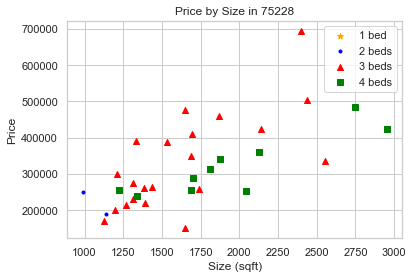

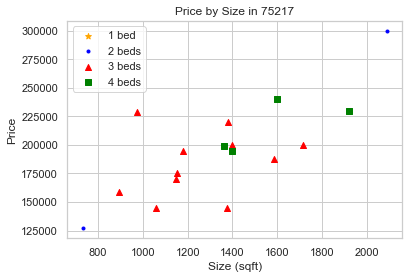

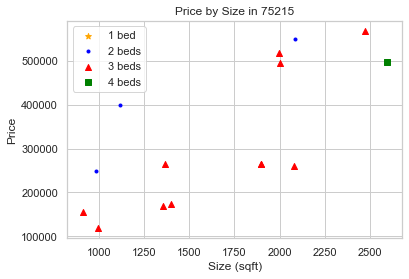

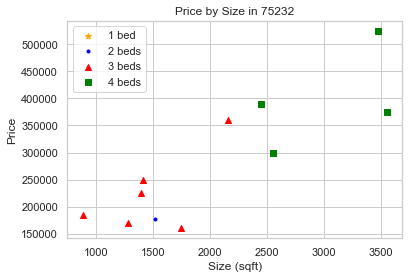

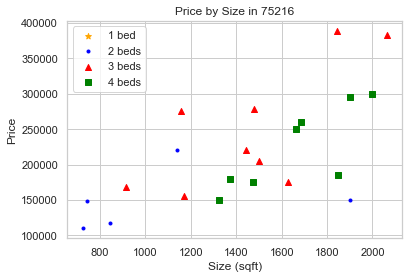

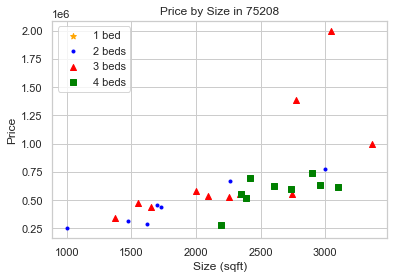

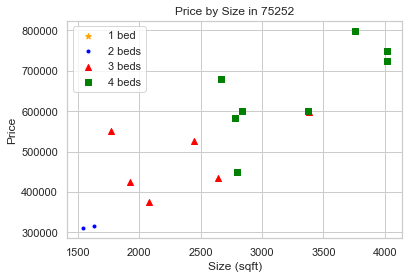

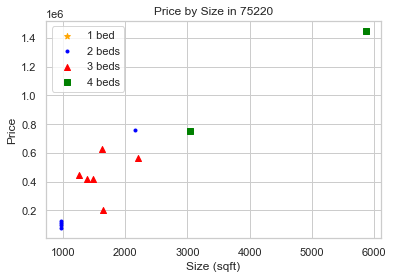

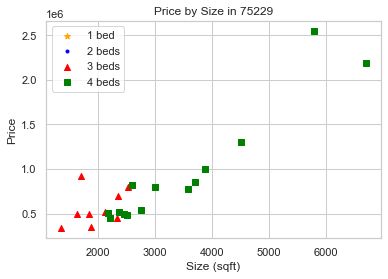

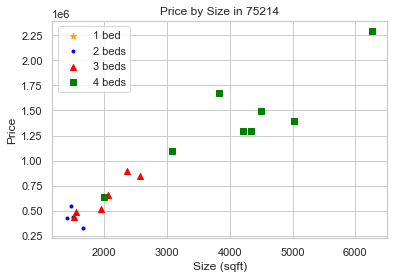

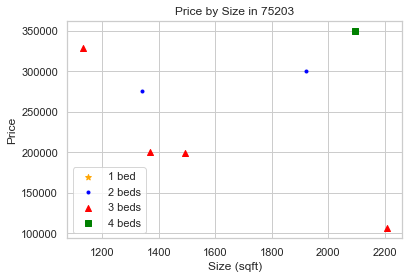

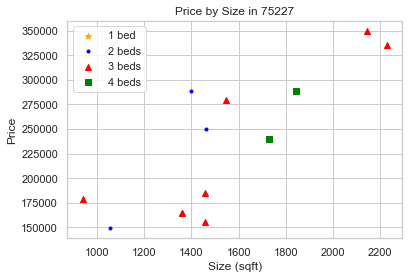

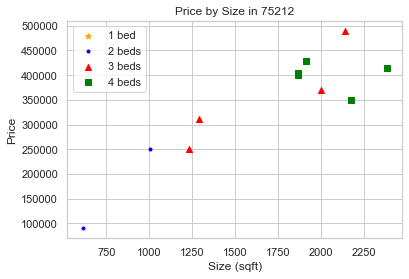

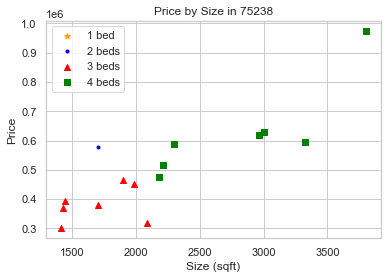

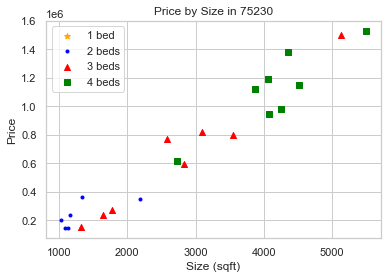

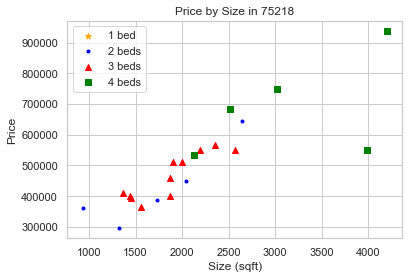

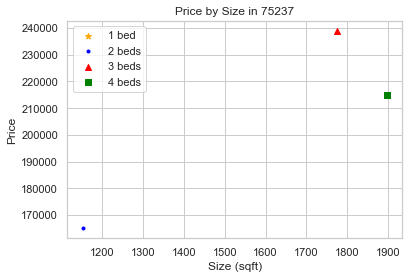

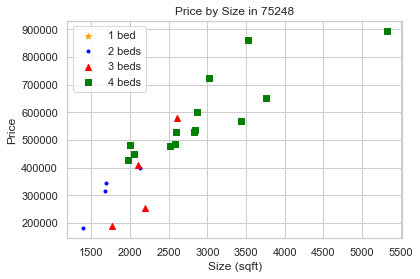

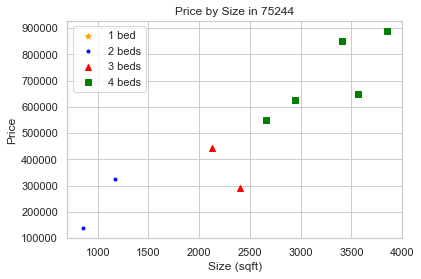

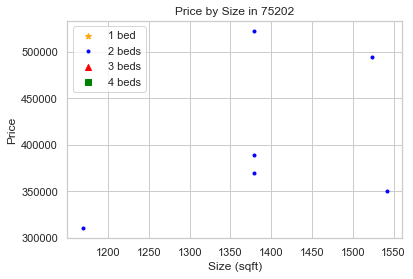

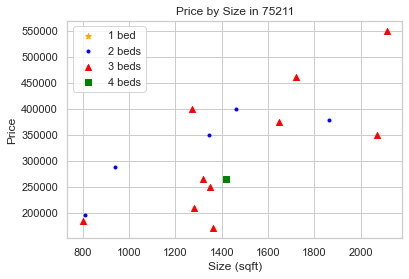

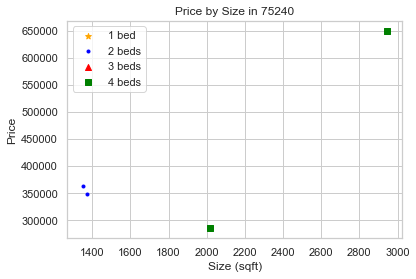

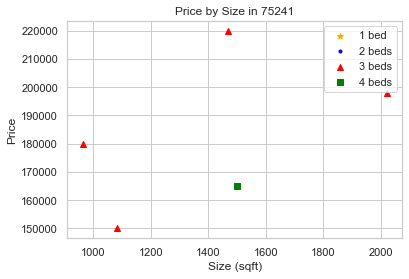

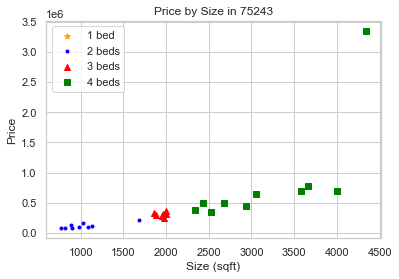

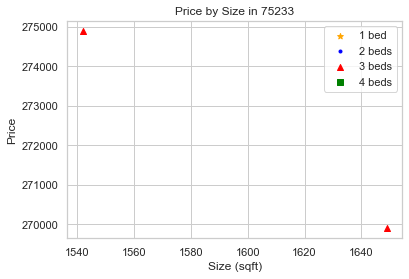

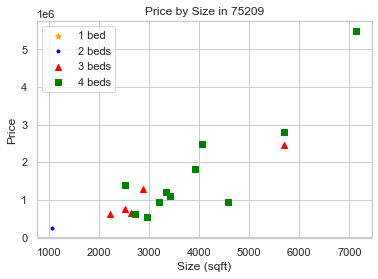

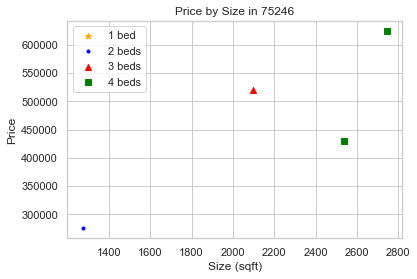

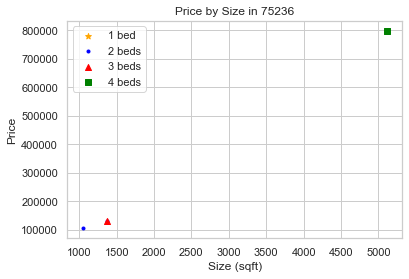

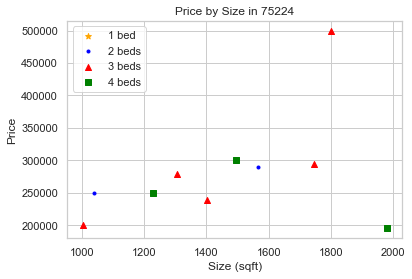

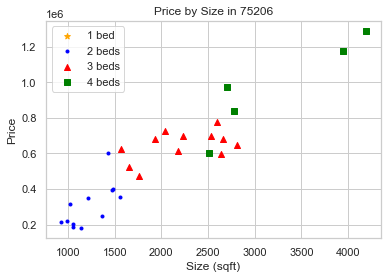

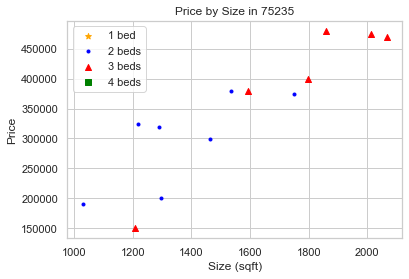

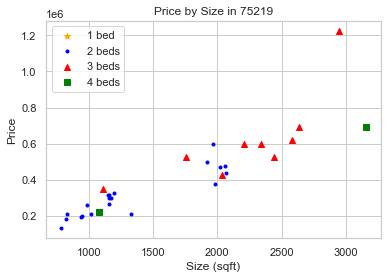

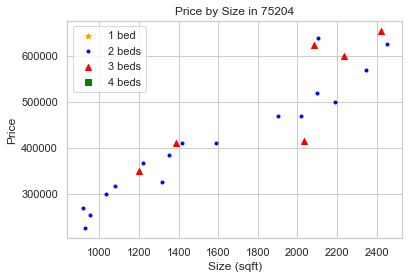

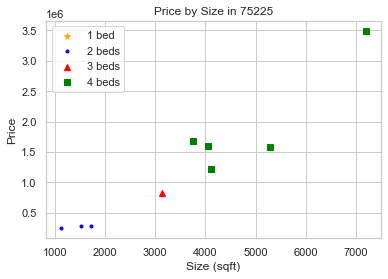

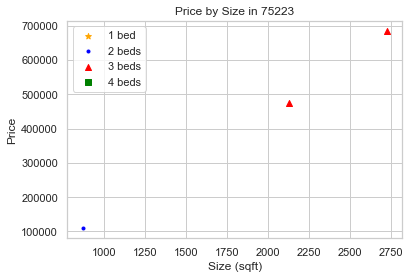

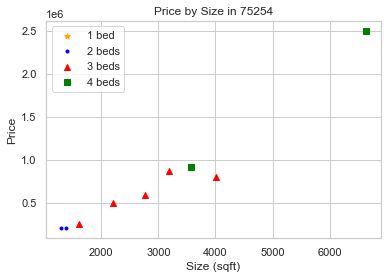

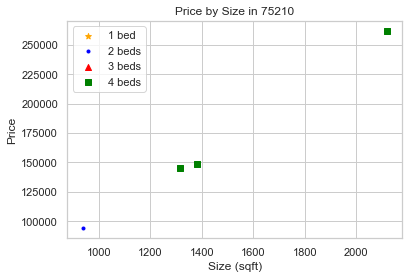

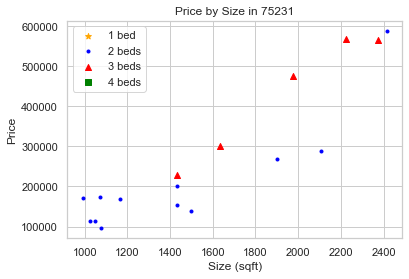

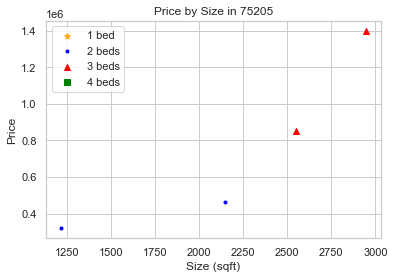

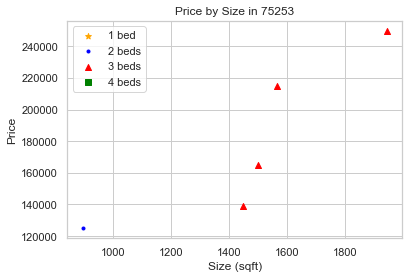

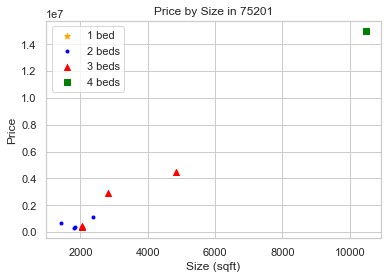

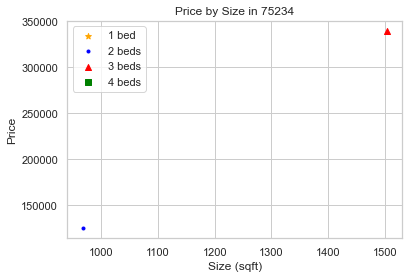

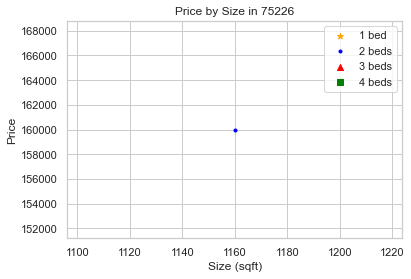

In [32]:
for zipcode in zipcodes:
    plot_scatter_chart(df,zipcode)
    plt.show()

--- place zipcodes into zones 

# Predictions

In [28]:
x = houses.dropna()
y = x[['price']]
x = x[['beds', 'baths', 'size']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=10)

In [29]:
linr = LinearRegression()
linr.fit(x_train,y_train)
linr.score(x_test,y_test)

0.6447765102096711

In [30]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.67652222, 0.63868895, 0.64751058, 0.70775542, 0.68228452])

##### not great- run again with more data 

----

In [31]:
def best_model(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

best_model(x,y)

,model,best_score,best_params
0,linear_regression,0.670552,{'normalize': True}
1,lasso,0.670552,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.407577,"{'criterion': 'mse', 'splitter': 'random'}"


#### decision tree gives the best results

In [ ]:
## decision tree predictions 

